# Analysis of Roll20 dice rolls

This notebook examines the dice rolls reported in the Roll20 chat for a given campaign, and the distribution of dice rolls for each character. This is based on the (typically human) experience of believing that my character seemed to be rolling a lot more nat 1s and other low numbers compared with my party members. Is it confirmation bias or is Roll20 really giving me dud rolls.

To use the notebook, you need to download the full chat log from your Roll20 campaign (open it in 'single page' mode and then do a Save As in the browser to capture the entire page and its resources -- though you only need the HTML) and then update the 'chatlog_fn' path, and also put your campaign's characters' names in the 'CHARACTERS' list. These need to match what is used in the chat log. 

**NB** As my DM uses a number of home brew rules and macros, some of the parsing logic may not make sense for your campaign.



In [1]:
from bs4 import BeautifulSoup
from random import randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [66]:
# chatlog_fn = 'Glaive of The Revenant King Roll20.htm'
# chatlog_fn = 'Chat Log for Glaive of The Revenant King.htm'
# chatlog_fn = 'Chat Log for Glaive of The Revenant King-20220309.htm'
chatlog_fn = 'Chat Log for Glaive of The Revenant King-20220608.html'  # in the current directory

with open(chatlog_fn, 'r', encoding='utf-8') as in_f:
    roll20_content = in_f.read()
    
print(f'{chatlog_fn}: {len(roll20_content):,} chars')

Glaive of The Revenant King Roll20.htm: 1,385,194 chars


In [67]:
soup = BeautifulSoup(roll20_content, 'html.parser')

In [68]:
# Constants and characters

VERBOSE = False
COUNT_INITIATIVE = True

CHARACTERS = [
   "Kiril Ah'hallan",
   "Penelope Merrythane",
   "Kane Khazim",
   "Lognek Oreheat",
   "Jester Feonista",
   "Aliyah Ramirez" 
]
CHARACTER_FNS = [ ch.split(' ')[0] for ch in CHARACTERS ]
CHAR_N1_FN_MAP = { ch.split(' ')[0] : ch for ch in CHARACTERS }
CHAR_FN_N1_MAP = { ch : ch.split(' ')[0] for ch in CHARACTERS }



In [69]:
general_messages = soup.find_all('div', class_='message')

print(f'Messages: {len(general_messages):,}')

def add_roll(roll_map, name, roll):
    if name not in roll_map:
        roll_map[name] = []
    roll_map[name].append(int(roll))
    
def extract_roll_text(text, before_roll, after_roll):
    bdr_idx = text.index(before_roll)
    next_lt = text.index(after_roll, bdr_idx)
    return text[bdr_idx + len(before_roll):next_lt]



crits = { ch : 0 for ch in CHARACTERS }
nat1s = { ch : 0 for ch in CHARACTERS }
initiatives = { ch : [] for ch in CHARACTERS } # first name only
all_rolls = {}
first_rolls = {}
other_rolls = {}  # message : count
try:
    for msg in general_messages:
        if msg.find('div', class_='sheet-charname'):
            charname = list(msg.find('div', class_='sheet-charname').children)[1].get_text()

            if VERBOSE: print(charname)
            if charname not in CHARACTERS: continue
                
            rolls = msg.find_all('span', class_='inlinerollresult')
            first_roll = True
            for r in rolls:
                r_str = str(r)
                if '"basicdiceroll"&gt;' in r_str:
                    roll = extract_roll_text(r_str, '"basicdiceroll"&gt;', '&lt;')
                elif '"basicdiceroll">' in r_str:
                    if 'Rolling 1d20' in r['title']:
                        roll = extract_roll_text(r['title'], '"basicdiceroll">', '<')
                        if 'critsuccess' in roll:
                            roll = '20'
                            crits[charname] += 1
                        elif 'critfail' in roll:
                            roll = '1'
                            nat1s[charname] += 1
                        if VERBOSE: print(roll)
                elif 'basicdiceroll critsuccess' in r_str:
                    roll = '20'
                    crits[charname] += 1
                elif 'basicdiceroll critfail' in r_str:
                    roll = '1'
                    nat1s[charname] += 1                    
                else:
                    # Luckstones, Tabard of Protection bonuses, and saves in spell descriptions
                    # print('---- CAN\'T FIND NUTHIN ----')
                    title_key = 'title'
                    if not r.get(title_key):
                        title_key = 'original-title'
                    if r[title_key] not in other_rolls:
                        other_rolls[r[title_key]] = 0
                    other_rolls[r[title_key]] += 1
                    # if 'Luckstone' not in r['title'] and 'SAVE' not in r['title'] and 'Tabard' not in r['title']:
                    #     print(r['title'])
                    continue
                if VERBOSE: print(roll)
                add_roll(all_rolls, charname, roll)
                if first_roll:
                    add_roll(first_rolls, charname, roll)
                    first_roll = False
        elif 'emote' in msg['class'] and 'for initiative!' in str(msg):
            # print(msg.get_text())
            # Examples (possibly homebrew):
            # Aaron Kiril rolls 9 for initiative!
            # Lognek Oreheat Penelope Merrythane rolls 13 for initiative!
            # Lognek Oreheat Lognek rolls 19 for initiative!
            terms = msg.get_text().split()

            charnames = set(terms[:terms.index('rolls')])
            for charname in charnames:
                if charname not in CHARACTER_FNS:
                    continue

                full_charname = CHAR_N1_FN_MAP[charname]

                raw_roll_text = str(list(msg.find_all('span', class_='inlinerollresult'))[0])
                if 'critsuccess' in raw_roll_text:
                    roll = '20'
                elif 'critfail' in raw_roll_text:
                    roll = '1'
                else:
                    roll = extract_roll_text(raw_roll_text, '"basicdiceroll"&gt;', '&lt;')
                # print(full_charname, roll)
                if COUNT_INITIATIVE:
                    add_roll(all_rolls, full_charname, roll)
                    add_roll(first_rolls, full_charname, roll)
                add_roll(initiatives, full_charname, roll)
except ValueError as e:
    print('------- BARF! --------')
    print(e)
    print(msg)
    
print('\nUnparseable rolls')
# look at these for guidance for what parsing conditions to add for your campaign.
# You may need to look back into the HTML to figure out what these map to and whether
# you want to capture them.
for msg, c in other_rolls.items():
    print(f'{c:>7,} : {msg}')
        
print(f'\nTotal rolls: {sum(len(rs) for rs in all_rolls.values()):,}')        

Messages: 101

Unparseable rolls
     12 : Rolling 1[Luckstone] = 1
      4 : Rolling 15[SAVE] = 15

Total rolls: 82


In [70]:
# Basic tables of rolls, crits and nat 1s. I'm sure this can be done more prettily.
print(f'All rolls ({sum(len(rs) for rs in all_rolls)})')
print('Name     \tRolls\tCrits\tCrits%\tNat1s\tNat1s%\tMean')
for n, rs in all_rolls.items():
    print(f'{n.split()[0]:<10}\t{len(rs):4d}\t{crits[n]:3d}\t{crits[n]/len(rs):5.1%}\t{nat1s[n]:3d}\t{nat1s[n]/len(rs):5.1%}\t{sum(rs) / len(rs):4.1f}')
print(f'\nFirst rolls ({sum(len(rs) for rs in first_rolls)})')
# Quite often Roll20 will provide two dice rolls, letting you decide whether the first roll is required
# or which roll depending on advantage or disadvantage
print('Name     \tRolls\tCrits\tCrits%\tNat1s\tNat1s%\tMean')
for n, rs in first_rolls.items():
    print(f'{n.split()[0]:<10}\t{len(rs):4d}\t{crits[n]:3d}\t{crits[n]/len(rs):5.1%}\t{nat1s[n]:3d}\t{nat1s[n]/len(rs):5.1%}\t{sum(rs) / len(rs):4.1f}')

    
the_rolls = all_rolls #initiatives #first_rolls

All rolls (88)
Name     	Rolls	Crits	Crits%	Nat1s	Nat1s%	Mean
Penelope  	  10	  0	 0.0%	  0	 0.0%	 9.1
Kane      	  15	  2	13.3%	  0	 0.0%	11.1
Jester    	  11	  1	 9.1%	  1	 9.1%	 8.4
Lognek    	  21	  0	 0.0%	  0	 0.0%	 9.0
Aliyah    	   4	  0	 0.0%	  0	 0.0%	 4.2
Kiril     	  21	  1	 4.8%	  0	 0.0%	 7.3

First rolls (88)
Name     	Rolls	Crits	Crits%	Nat1s	Nat1s%	Mean
Penelope  	   6	  0	 0.0%	  0	 0.0%	 9.3
Kane      	   9	  2	22.2%	  0	 0.0%	11.2
Jester    	   7	  1	14.3%	  1	14.3%	11.7
Lognek    	   9	  0	 0.0%	  0	 0.0%	 9.6
Aliyah    	   4	  0	 0.0%	  0	 0.0%	 4.2
Kiril     	   8	  1	12.5%	  0	 0.0%	 6.9


Text(0.5, 1.0, 'Frequency of dice rolls by characters')

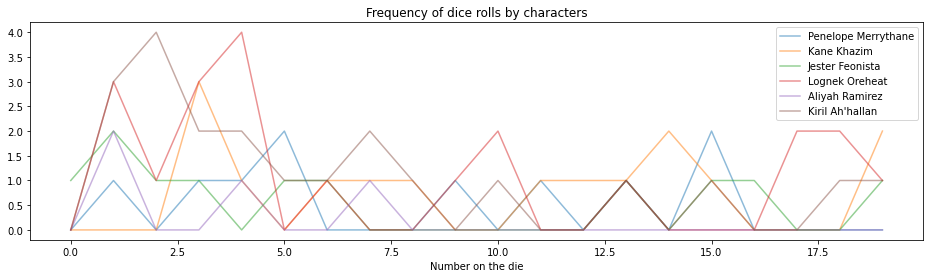

In [71]:
# How often did each character roll each die value?
def build_rolls_df(rolls):
    cols = list(rolls.keys())
    def count_rolls(rs):
        return [ rs.count(i) for i in range(1, 21) ]
    return pd.DataFrame(
        { ch : count_rolls(rolls[ch]) for ch in cols },
        columns=cols
    )

rolls_df = build_rolls_df(the_rolls)

# ax = rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
ax = rolls_df.plot.line(figsize=(16, 4), alpha=0.5)

ax.set_xlabel('Number on the die')
ax.set_title('Frequency of dice rolls by characters')

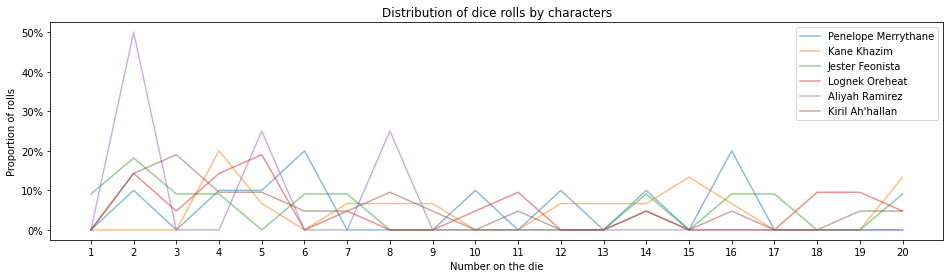

In [72]:
# what proportion of each characters' die rolls had each die value?
def build_rolls_norm_df(rolls):
    cols = list(rolls.keys())
    def count_rolls_norm(rs):
        return [ 100 * rs.count(i) / len(rs) for i in range(1, 21) ]
    return pd.DataFrame(
        { ch : count_rolls_norm(rolls[ch]) for ch in cols },
        columns=cols,
        index=[i for i in range(1, 21)]
    )

norm_rolls_df = build_rolls_norm_df(the_rolls)

# ax = rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
ax = norm_rolls_df.plot.line(figsize=(16, 4), alpha=0.5)

ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 21)]))
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of dice rolls by characters')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

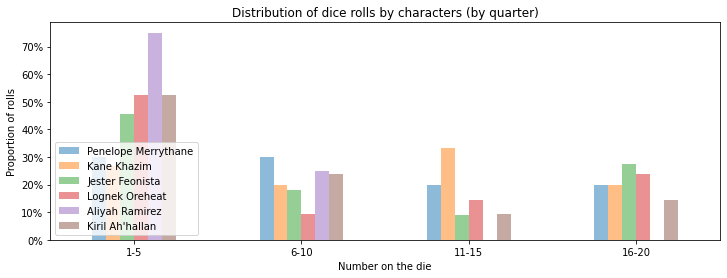

In [73]:
# Break it down into quarters: 1-5, 6-10, 11-15, 16-20
def build_rolls_norm_q_df(rolls):
    cols = list(rolls.keys())
    def count_rolls_norm_q(rs):
        binned = [ 100 * rs.count(i) / len(rs) for i in range(1, 21) ]
        in_quarters = [
            sum(binned[:5]), sum(binned[5:10]), sum(binned[10:15]), sum(binned[15:])
        ]
        return in_quarters
    return pd.DataFrame(
        { ch : count_rolls_norm_q(rolls[ch]) for ch in cols },
        columns=cols,
        index=['1-5', '6-10', '11-15', '16-20']
    )

norm_rolls_q_df = build_rolls_norm_q_df(the_rolls)

ax = norm_rolls_q_df.plot.bar(figsize=(12, 4), alpha=0.5, rot=0)

ax.legend(loc='lower left')
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of dice rolls by characters (by quarter)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())



Text(0.5, 1.0, 'Dice rolls by characters')

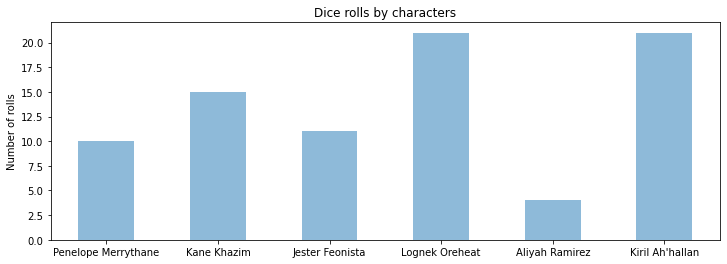

In [74]:
# Who rolls most frequently?
def build_roll_count_df(rolls):
    cols = list(rolls.keys())
    return pd.DataFrame(
        { 'Rolls': [ len(rolls[ch]) for ch in cols ] },
        index=cols
    )

roll_counts_df = build_roll_count_df(the_rolls)

ax = roll_counts_df.plot(kind='bar', alpha=0.5, rot=0.0, figsize=(12, 4), legend=False)
ax.set_ylabel('Number of rolls')
ax.set_title('Dice rolls by characters')


Text(0.5, 1.0, 'Initiative rolls by characters')

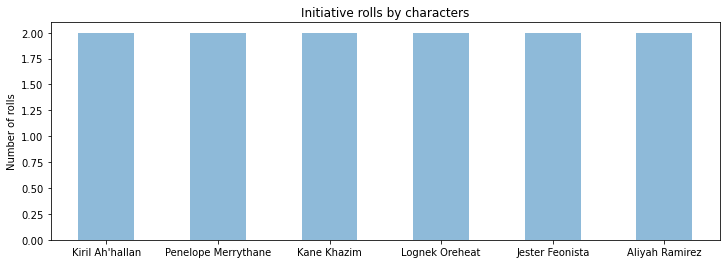

In [75]:
# Look at initiative rolls specifically.
# Ideally these should be identical, right? Maybe I'm missing initiative sometimes.
# Sometimes we make mistakes and have to roll it again too, so those botched rolls are
# still considered here.
# FYI, my DM gets us to roll initiative every round of combat, rather than just at the start.
init_roll_counts_df = build_roll_count_df(initiatives)

ax = init_roll_counts_df.plot(kind='bar', alpha=0.5, rot=0.0, figsize=(12, 4), legend=False)
ax.set_ylabel('Number of rolls')
ax.set_title('Initiative rolls by characters')

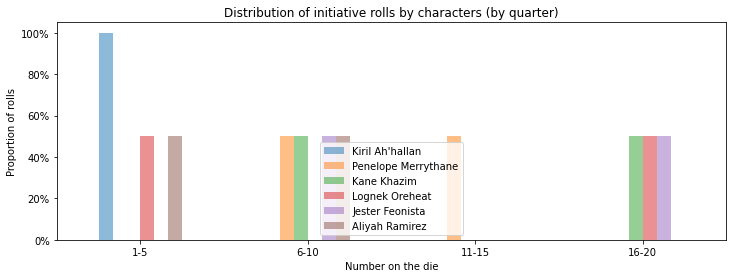

In [76]:
# normalised initiative rolls by quarter
norm_init_rolls_q_df = build_rolls_norm_q_df(initiatives)

ax = norm_init_rolls_q_df.plot.bar(figsize=(12, 4), alpha=0.5, rot=0)

ax.legend(loc='lower center')
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of initiative rolls by characters (by quarter)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

d20, 10,000 samples

Mean NORMAL       : 10.6246
Mean ADVANTAGE    : 13.719
Mean DISADVANTAGE : 7.132


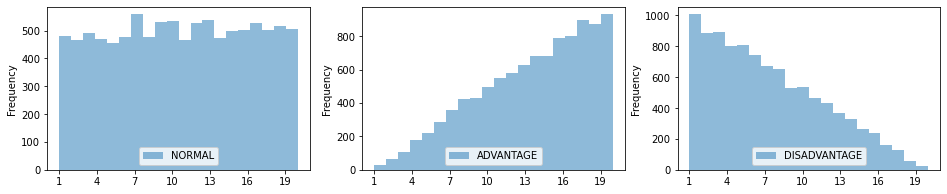

In [77]:
# Me running some experiments

# Roll distributions
def carry_out_roll_distribution_experiments():

    NORMAL = 'NORMAL'
    ADVANTAGE = 'ADVANTAGE'
    DISADVANTAGE = 'DISADVANTAGE'
    MODES = [NORMAL, ADVANTAGE, DISADVANTAGE]

    def plot_distributions(rolls_df, die=20, step=3):
#         rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
        fig, axes = plt.subplots(1, 3, figsize=(16, 3))

        for i, col in enumerate(MODES):
            rolls_df[[col]].plot.hist(bins=20, ax=axes[i], alpha=0.5)
            axes[i].legend(loc='lower center')
            axes[i].xaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, die + 1, step)]))

#             ax.set_

    def create_rolls(die=20, mode=NORMAL, pop_size=1000):
        def roll_dice():
            if mode == ADVANTAGE:
                return max(randint(1, die), randint(1, die))
            elif mode == DISADVANTAGE:
                return min(randint(1, die), randint(1, die))
            elif mode == NORMAL:
                return randint(1, die)
        return [roll_dice() for _ in range(pop_size)]

    die = 20
    step = 3
    pop_size = 10000
    rolls_df = pd.DataFrame(
        { m : create_rolls(die=die, pop_size=pop_size, mode=m) for m in MODES },
        columns = MODES
    )
    print(f'd{die}, {pop_size:,} samples\n')
    for m in MODES:
        print('Mean', f'{m:<13}:', rolls_df[[m]].mean().get(0))

    plot_distributions(rolls_df, die, step)
    
carry_out_roll_distribution_experiments()